# **SVHN classification with CNN**

**Importing the dataset**

In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets


In [34]:
transform = transforms.Compose([
                    
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Transforms to convert Image --> Tensor

In [35]:
trainset  = torchvision.datasets.SVHN('./data', split='train',download=True,transform=transform)
testset =  torchvision.datasets.SVHN('./data', split='test',download=True,transform=transform)


Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [36]:
# Set up the dataloaders to be used in training and testing

train_loader = torch.utils.data.DataLoader(dataset=testset,
                                              batch_size=64,
                                              shuffle=True,
                                              )
test_loader = torch.utils.data.DataLoader(dataset=trainset,
                                              batch_size=64,
                                              shuffle=True,
                                              )


In [37]:
#Importing libraries
import numpy as np
import pandas as pd
import keras
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [38]:
#Loading train and test data
from scipy.io import loadmat
train = loadmat('./data/train_32x32.mat')
test = loadmat('./data/test_32x32.mat')

x_train = train['X']
y_train = train['y']
x_test = test['X']
y_test = test['y']
print("Training shapes:",x_train.shape,y_train.shape)
print("Training shapes:",x_test.shape,y_test.shape)

Training shapes: (32, 32, 3, 73257) (73257, 1)
Training shapes: (32, 32, 3, 26032) (26032, 1)


In [39]:
# Fixing the axes of the images

x_train = np.moveaxis(x_train, -1, 0)
x_test = np.moveaxis(x_test, -1, 0)

print(x_train.shape)
print(x_test.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


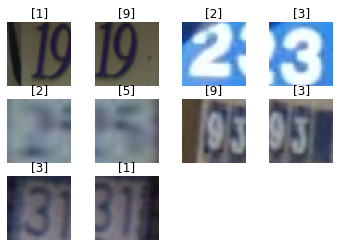

In [40]:
#Visualising the first 10 images with their labels
def plot_images(images,labels,cols=4):
    num = len(images)
    rows = num//cols 
    if num % cols != 0:
        rows += 1
    for i in range(num):
        plt.subplot(rows,cols,i+1)
        plt.imshow(images[i])
        plt.title(str(labels[i]))
        plt.axis("off")
    plt.show()

plot_images(x_train[:10],y_train[:10])

In [41]:
#Changing the dtype of data
x_train=x_train.astype('float',copy=False)
x_test=x_test.astype('float',copy=False)

In [42]:
print('Min:', x_train.min(), 'Max:', x_train.max())

Min: 0.0 Max: 255.0


In [43]:
# Normalizing by dividing by 255 as the data is in terms of pixels
x_train /= 255.0
x_test /= 255.0

In [44]:
#Changing the label 10 to 0
for i in range(0,73257):
  if y_train[i]==10:
    y_train[i]=0

for i in range(0,26032):
  if y_test[i]==10:
    y_test[i]=0

y_train

array([[1],
       [9],
       [2],
       ...,
       [1],
       [6],
       [9]], dtype=uint8)

In [45]:
#One hot encoding of labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [46]:
# Data augmentation

datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

# **Test Model**

In [47]:
dropout_rate = 0.2
K = keras.backend
resnet_0= keras.models.Sequential([
                                  keras.layers.Lambda(lambda x:x/255,input_shape=x_train.shape[1:]),
                                  keras.layers.Conv2D(32,3,activation="relu",use_bias=False),
                                  keras.layers.BatchNormalization(),
                                  keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"),
                                  keras.layers.Dropout(dropout_rate),
                                  
                                  keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"),
                                  keras.layers.Dropout(dropout_rate),
                                  
                                  keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"),
                                  keras.layers.Dropout(dropout_rate),
                                  keras.layers.Flatten(),
                                  keras.layers.Dense(128,activation="relu"),
                                  keras.layers.Dense(10,activation="softmax")
])

In [48]:
#Optimizing and compiling
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = keras.optimizers.Adam(lr=1e-4, amsgrad=True)
resnet_0.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [49]:
 #Fit model in order to determine best learning rate

history = resnet_0.fit_generator(datagen.flow(x_train, y_train, batch_size=128),epochs=30, callbacks=[lr_schedule])

Epoch 1/30
573/573 [==============================] - 32s 56ms/step - loss: 2.2461 - accuracy: 0.1877
Epoch 2/30
573/573 [==============================] - 32s 56ms/step - loss: 2.2106 - accuracy: 0.2008
Epoch 3/30
573/573 [==============================] - 32s 56ms/step - loss: 2.1038 - accuracy: 0.2532
Epoch 4/30
573/573 [==============================] - 33s 57ms/step - loss: 1.9554 - accuracy: 0.3240
Epoch 5/30
573/573 [==============================] - 33s 57ms/step - loss: 1.8342 - accuracy: 0.3749
Epoch 6/30
573/573 [==============================] - 32s 56ms/step - loss: 1.7496 - accuracy: 0.4060
Epoch 7/30
573/573 [==============================] - 33s 57ms/step - loss: 1.6894 - accuracy: 0.4276
Epoch 8/30
573/573 [==============================] - 32s 56ms/step - loss: 1.6429 - accuracy: 0.4455
Epoch 9/30
573/573 [==============================] - 32s 57ms/step - loss: 1.6004 - accuracy: 0.4594
Epoch 10/30
573/573 [==============================] - 32s 56ms/step - loss: 1.554

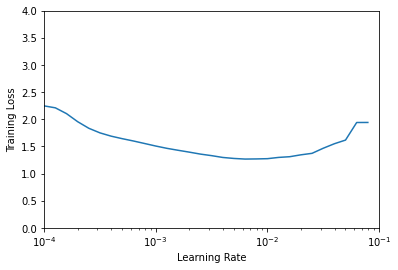

In [50]:
# Plot Learning Rate vs. Loss

plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-4, 1e-1, 0, 4])
plt.xlabel('Learning Rate')
plt.ylabel('Training Loss')
plt.show()

# **FINAL MODEL**

In [51]:
dropout_rate = 0.2
resnet_1 = keras.models.Sequential([
                                  keras.layers.Lambda(lambda x:x/255,input_shape=x_train.shape[1:]),
                                  keras.layers.Conv2D(32,3,activation="relu",use_bias=False),
                                  keras.layers.BatchNormalization(),
                                  keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"),
                                  keras.layers.Dropout(dropout_rate),
                                  
                                  keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"),
                                  keras.layers.Dropout(dropout_rate),
                                  
                                  keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"),
                                  keras.layers.Dropout(dropout_rate),
                                  keras.layers.Flatten(),
                                  keras.layers.Dense(128,activation="relu"),
                                  keras.layers.Dense(10,activation="softmax")
])

In [53]:
#Optimizing and compiling
early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True)
resnet_1_checkpoint = keras.callbacks.ModelCheckpoint('/kaggle/working/best_cnn.h5', save_best_only=True)
resnet_1.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [55]:
resnet_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        864       
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 32)         

In [57]:
# Fit model in order to make predictions

history = resnet_1.fit_generator(datagen.flow(x_train, y_train, batch_size=128),
                              epochs=70, 
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/70
573/573 [==============================] - 33s 57ms/step - loss: 2.0855 - accuracy: 0.2605
Epoch 2/70
573/573 [==============================] - 31s 55ms/step - loss: 1.7629 - accuracy: 0.3988
Epoch 3/70
573/573 [==============================] - 31s 55ms/step - loss: 1.6791 - accuracy: 0.4272
Epoch 4/70
573/573 [==============================] - 31s 54ms/step - loss: 1.6301 - accuracy: 0.4464
Epoch 5/70
573/573 [==============================] - 31s 54ms/step - loss: 1.5903 - accuracy: 0.4588
Epoch 6/70
573/573 [==============================] - 31s 54ms/step - loss: 1.5522 - accuracy: 0.4732
Epoch 7/70
573/573 [==============================] - 30s 53ms/step - loss: 1.5246 - accuracy: 0.4828
Epoch 8/70
573/573 [==============================] - 31s 54ms/step - loss: 1.4959 - accuracy: 0.4936
Epoch 9/70
573/573 [==============================] - 31s 54ms/step - loss: 1.4761 - accuracy: 0.5000
Epoch 10/70
573/573 [==============================] - 30s 53ms/step - loss: 1.454

In [58]:
# Evaluating model on test data
test_loss, test_acc = resnet_1.evaluate(x=x_test, y=y_test, verbose=0)

#Checking the accuracy of the model
print('Test accuracy is:',test_acc, 'Test loss is: ', test_loss)

Test accuracy is: 0.6827750205993652 Test loss is:  1.0621013641357422


Accuracy : 68.27%

# **Saving model**

In [59]:
resnet_1.save('models/CNN.h5')